#### AirBNB Seattle dataset

First read in the necessary libraries.

In [161]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# import AllTogether as t
import seaborn as sns
%matplotlib inline

#### Listings.csv

Take a look at the data set describing all the different appartments that are being offered at airBNB.

In [162]:
df_listing = pd.read_csv('listings.csv')
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### Reviews.csv

Take a look at the data set describing the different reviews.

In [6]:
df_reviews = pd.read_csv('reviews.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


#### Calendar.csv

Take a look at the data set describing the different bookings for an appartment.

In [163]:
df_calendar = pd.read_csv('calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### Data Preperation

Create a dataframe that contains the information about how often an appartment is booked. Later on it turned out that the column that I calculated here already existed in the listings.csv file:)

In [164]:
# First do some group by and pivotting to get the information we need.
df_occupied = pd.DataFrame(pd.pivot_table(df_calendar.groupby(['listing_id', 'available']).count()['date'].reset_index(),index=["listing_id"], columns='available', values='date').reset_index(), columns=['listing_id', 'f', 't']).fillna(0)
# Then rename our columns
df_occupied.columns = ['listing_id', 'available', 'occupied']

# Create a column percentage that shows how often an appartment is occupied. This will be our main value that we want to demistify
df_occupied['percentage'] = df_occupied['occupied'] / (df_occupied['available'] + df_occupied['occupied'])

# First I made sure that all apprtaments contained 365 rows in the calendar.csv and then concluded that we don't need the available and occupied column.
# So we can remove the other unnecessary columns
df_occupied.drop(['available', 'occupied'], axis=1, inplace=True)

#### Merge the data of calendar.csv and listing.csv

Now we want to create a dataframe that contains data about the appartments and their occupation.

In [192]:
# Join two columns
data = df_listing.merge(df_occupied, left_on='id', right_on='listing_id', how='inner')

In [193]:
# The ID's in this dataframe were only usefull for making joins between the datasets, but not for any sort of prediction.
# Therefore we drop the ID columns.
data.drop(['id', 'scrape_id', 'host_id','listing_id', 'latitude', 'longitude', 'license'], axis=1, inplace=True)

Make sure we remove columns that don't have any additional value, like columns that have a lot of data missing.

Prep the data column that contain pricing information, remove preceding $ and thousand seperator ','.

In [194]:
# The pricing column contains all prices in dollars, but these are stored as an object. First we need to remove the $
cols_to_check = ['price', 'weekly_price', 'monthly_price']
for col in cols_to_check:
    data[col] = data[col].apply(lambda x : x[1:].replace(",", "") if str(x).startswith("$") else x)
# Then we need to cast these columns to float.
data[cols_to_check] = data[cols_to_check].astype(float)

An interesting thing to look at might be the correlation heatmap

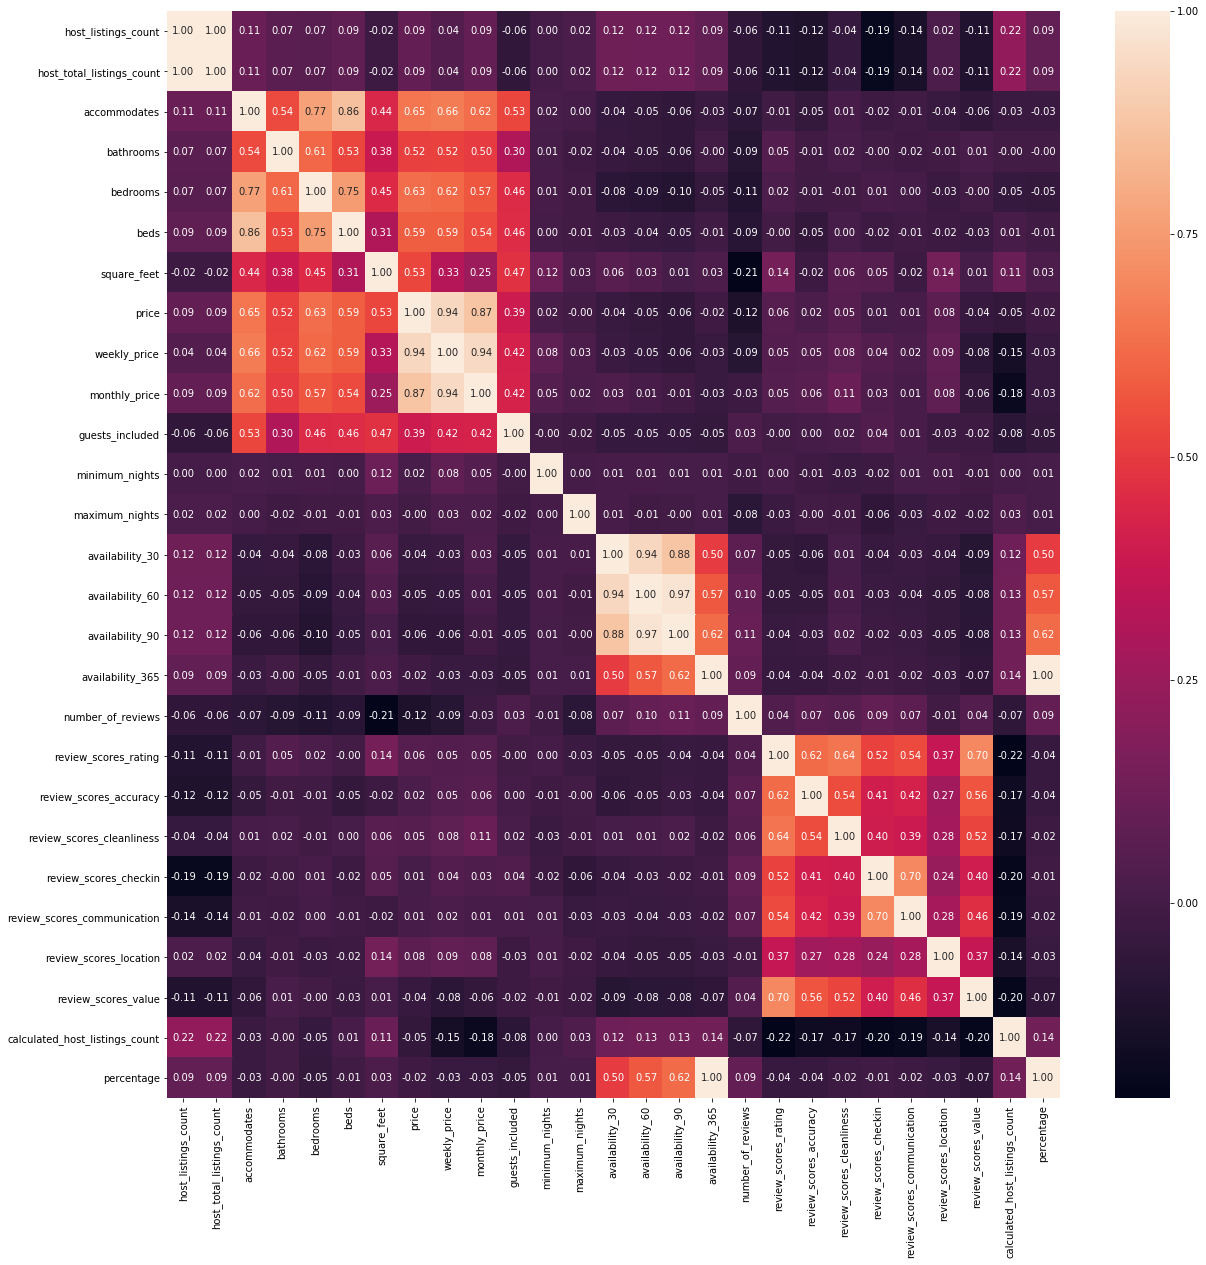

In [195]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".2f");

In [ ]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['Salary'], axis=0)
    y = df['Salary']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'ExpectedSalary', 'Salary'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    

In [ ]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = t.find_optimal_lm_mod(X, y, cutoffs)

#### Question 4

**4.** Use the output and above plot to correctly fill in the keys of the **q4_piat** dictionary with the correct variable.  Notice that only the optimal model results are given back in the above - they are stored in **lm_model**, **X_train**, **X_test**, **y_train**, and **y_test**.  If more than one answer holds, provide a tuple holding all the correct variables in the order of first variable alphabetically to last variable alphabetically.